# VAE Conditioned Diffusion Model
In this notebook, I trained a conditional diffusion model from diffusers package. I utilized my self trained variational autoencoder (vae) to condition every sample.  

# Environment Setup

## pips

In [ ]:
!pip install boto3

In [ ]:
!pip install diffusers

In [ ]:
!pip install accelerate

In [ ]:
!pip install datasets

## imports and config

In [ ]:
import librosa
import numpy as np
from PIL import Image
from IPython.display import Audio, display
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from torchvision import transforms
from torchvision.transforms import Compose, Normalize, ToTensor, ToPILImage
from diffusers import UNet2DModel, UNet2DConditionModel, DDPMPipeline, DDPMScheduler
from transformers import AdamW, get_scheduler
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from pathlib import Path
from typing import Optional
from diffusers.optimization import get_cosine_schedule_with_warmup


In [ ]:
from dataclasses import dataclass

import os
os.environ["HF_TOKEN"] = "<your_hf_access_token>"

@dataclass
class TrainingConfig:
    image_size: int = 256  # the generated image resolution
    sample_rate: int = 22050  # the sample rate of the audio
    train_batch_size: int = 18
    eval_batch_size: int = 1  # how many images to sample during evaluation
    guidance_scale: float = 7.5  # the guidance scale for the diffusion process
    start_epoch: int = 0
    num_epochs: int = 70
    num_progress_images: int = 10
    gradient_accumulation_steps: int = 1
    num_inference_steps: int = 1000  # the number of diffusion steps to take
    learning_rate: float = 1e-4
    lr_warmup_steps: int = 500
    save_image_epochs: int = 10
    save_model_epochs: int = 10
    mixed_precision: str = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir: str = "out"  # the model name locally and on the HF Hub
    resume_epoch: int = 0  # the epoch to resume training from
    resume_training: bool = False
    push_to_hub: bool = True  # whether to upload the saved model to the HF Hub
    hub_model_id: str = "<your-hub-model-id>"  # the name of the repository to create on the HF Hub
    hub_private_repo: bool = True
    overwrite_output_dir: bool = True  # overwrite the old model when re-running the notebook
    seed: int = 0
    drive_dir: str = "/content/drive/<your_drive_dir>"


config = TrainingConfig()

## vae

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
from torch import nn
import torch.nn.functional as F


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class Encoder(nn.Module):
    def __init__(self, input_channels=1, hidden_dims=[512, 256, 128, 64, 32], latent_dim=16):
        super(Encoder, self).__init__()
        self.hidden_dims = hidden_dims

        # Build Encoder with Residual Blocks
        modules = []
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(input_channels, h_dim, kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                    ResidualBlock(h_dim)  # Adding a residual block
                )
            )
            input_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*8*8, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*8*8, latent_dim)

    def forward(self, x):
        for layer in self.encoder:
            x = layer(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim=16, output_channels=1, hidden_dims=[512, 256, 128, 64, 32]):
        super(Decoder, self).__init__()
        self.hidden_dims = hidden_dims
        # Reversing the order for the decoder
        hidden_dims = hidden_dims[::-1]
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[0]*8*8)



        # Build Decoder with Residual Blocks
        modules = []
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i], hidden_dims[i+1], kernel_size=3, stride=2, padding=1, output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i+1]),
                    nn.LeakyReLU(),
                    ResidualBlock(hidden_dims[i+1])  # Adding a residual block
                )
            )

        self.decoder = nn.Sequential(*modules)
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1], hidden_dims[-1], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1], output_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        z = self.decoder_input(z)
        z = z.view(-1, 512, 8, 8)
        for layer in self.decoder:
            z = layer(z)
        result = self.final_layer(z)
        return result

class VAE(nn.Module):
    def __init__(self,
                 input_channels=1,
                 latent_dim=16,
                 hidden_dims=None):
        super(VAE, self).__init__()

        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        self.encoder = Encoder(input_channels=input_channels,
                               hidden_dims=hidden_dims,
                               latent_dim=latent_dim)

        self.decoder = Decoder(latent_dim=latent_dim,
                               output_channels=input_channels,
                               hidden_dims=hidden_dims)

    def encode(self, input):
        mu, log_var = self.encoder(input)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, input):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

# Loss function for VAE
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [ ]:
vae = torch.load('/content/drive/<my_self_trained_vae_path>').to(device)

# Dataset & Dataloader

In [ ]:
class Mel:
  def __init__(
        self,
        file_path: str = None,
        spectrogram: Optional[np.ndarray] = None,
        image: Image.Image= None,
        x_res: int = 256,
        y_res: int = 256,
        sample_rate: int = config.sample_rate,
        n_fft: int = 2048,
        hop_length: int = 512,
        top_db: int = 80,
        n_iter: int = 32):
    self.hop_length = hop_length
    self.sr = sample_rate
    self.n_fft = n_fft
    self.top_db = top_db
    self.n_iter = n_iter
    self.x_res = x_res
    self.y_res = y_res
    self.n_mels = self.y_res
    self.slice_size = self.x_res * self.hop_length - 1
    self.file_path = file_path
    self.spectrogram = spectrogram
    self.image = image

    if file_path is not None and not isinstance(file_path, str):
        raise ValueError("file_path must be a string")
    if spectrogram is not None and not isinstance(spectrogram, np.ndarray):
        raise ValueError("spectrogram must be an ndarray")
    if image is not None and not isinstance(image, Image.Image):
        raise ValueError("image must be a PIL Image")

    if file_path is not None:
      self.load_file()
    elif image is not None:
      self.load_spectrogram()
    elif spectrogram is not None:
      self.load_image()
    else:
      print("both file path and image is none!")


  def load_file(self):
    try:
      # load
      if ".wav" in self.file_path:
        audio, _ = librosa.load(self.file_path, mono=True, sr=self.sr)
      # pad
      if len(audio) < self.x_res * self.hop_length:
              audio = np.concatenate([audio, np.zeros((self.x_res * self.hop_length - len(audio),))])
      # mel spectrogram
      S = librosa.feature.melspectrogram(
              y=audio, sr=self.sr, n_fft=self.n_fft, hop_length=self.hop_length, n_mels=self.n_mels
          )
      log_S = librosa.power_to_db(S, ref=np.max, top_db=self.top_db)
      log_S = log_S[:256, :256]
      self.spectrogram = (((log_S + self.top_db) * 255 / self.top_db).clip(0, 255) + 0.5).astype(np.uint8)
      # normalize
      # self.spectrogram = self.spectrogram / 255.0
      self.image = Image.fromarray(self.spectrogram)
    except Exception as e:
      print(f"Error loading {self.file_path}: {e}")


  def load_spectrogram(self):
    self.spectrogram = np.array(self.image)

  def load_image(self):
    self.spectrogram = self.spectrogram.astype("uint8")
    self.image = Image.fromarray(self.spectrogram)

  def get_spectrogram(self):
    return self.spectrogram

  def get_image(self):
    return self.image

  def get_audio(self):
    # denormalize
    # self.spectrogram = self.spectrogram * 255.0
    log_S = self.spectrogram.astype("float") * self.top_db / 255 - self.top_db
    S = librosa.db_to_power(log_S)
    audio = librosa.feature.inverse.mel_to_audio(
        S, sr=self.sr, n_fft=self.n_fft, hop_length=self.hop_length, n_iter=self.n_iter
    )
    display(Audio(audio, rate=self.sr))



  def plot_spectrogram(self):
    plt.figure(figsize=(10, 4))
    plt.imshow(self.spectrogram, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Magnitude')
    plt.title('Mel Spectrogram')
    plt.xlabel('Time (frames)')
    plt.ylabel('Frequency (Mel bins)')
    plt.tight_layout()
    plt.show()


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Normalize
from datasets import load_dataset
from PIL import Image

class HFDataset(Dataset):
    def __init__(self, dataset, vae_model):
        self.dataset = dataset
        self.transform = Compose([
            ToTensor(),
            Normalize([0.5], [0.5])  # Normalizing to have data between [-1, 1]
        ])
        self.model = vae_model

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample['image']  # Convert array to PIL image (if necessary)

        if image.mode != 'L':
            image = image.convert('L')
        image = self.transform(image)

        denormalize = transforms.Normalize(mean=[-m/s for m, s in zip([0.5], [0.5])], std=[1/s for s in [0.5]])
        vae_input = denormalize(image)
        vae_input = vae_input.unsqueeze(0).to(device)
        with torch.no_grad():
            mu, log_var = self.model.encode(vae_input)
            vae_latent_vector = torch.cat((mu, log_var), dim=1)
            min_val = vae_latent_vector.min()
            max_val = vae_latent_vector.max()
            normalized_tensor = 2 * ((vae_latent_vector - min_val) / (max_val - min_val)) - 1
            vae_latent_vector = normalized_tensor

        return image.to(device), vae_latent_vector.to(device)

        return image

# Load dataset from Hugging Face
dataset = load_dataset("teticio/audio-diffusion-256", split='train')

# Create an instance of the HFDataset
hf_dataset = HFDataset(dataset, vae)

# Create a DataLoader
data_loader = DataLoader(hf_dataset, batch_size=10, shuffle=True)  # Adjust batch size as per your config

# Example: Iterate over the DataLoader
for batch in data_loader:
    print(batch[0].shape)  # Expected output: torch.Size([batch_size, 1, 256, 256])
    print(batch[1].shape)
    break


torch.Size([10, 1, 256, 256])
torch.Size([10, 1, 64])


In [ ]:
image, latent= hf_dataset.__getitem__(8)
print(image)
print(latent)

tensor([[[-0.0980, -0.1765, -0.3569,  ..., -0.0353, -0.0980, -0.0118],
         [-0.1373, -0.2157, -0.2000,  ...,  0.0275,  0.0980,  0.0667],
         [-0.1373, -0.1765,  0.0588,  ...,  0.2235,  0.3020,  0.1059],
         ...,
         [-0.9137, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.7176],
         [-0.9137, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.7176],
         [-0.9137, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -0.7176]]],
       device='cuda:0')
tensor([[ 0.7212,  0.9075,  0.7456,  0.7315,  0.7325,  0.8880,  0.7356,  0.8223,
          0.9383,  0.8779,  0.5063,  0.7547,  0.9242,  0.7068,  0.7223,  0.7599,
          0.9026,  0.6326,  0.9529,  0.8430,  0.5565,  0.7552,  0.6628,  0.8574,
          1.0000,  0.7489,  0.5856,  0.9638,  0.6020,  0.8435,  0.7923,  0.9656,
         -0.7303, -0.7399, -0.7488, -0.7593, -0.7020, -0.6615, -0.8523, -0.6718,
         -0.6644, -0.7220, -0.6909, -0.6677, -0.7726, -0.6518, -0.6389, -0.7409,
         -0.7154, -0.7165, -0.7102, -0.9085, -0.

In [ ]:
denormalize = transforms.Normalize(
    mean=[-m/s for m, s in zip([0.5], [0.5])],
    std=[1/s for s in [0.5]]
)

def tensor_to_mel(tensor):
    dn_tensor=  denormalize(tensor.detach().cpu())
    s = np.array(dn_tensor.squeeze())*255
    return Mel(spectrogram=s)

torch.Size([1, 256, 256])


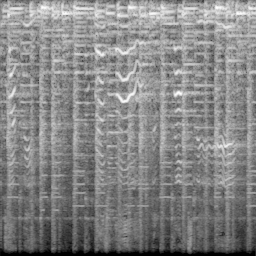

In [ ]:
tensor, latent = hf_dataset.__getitem__(8)
print(tensor.shape)
mel = tensor_to_mel(tensor)
mel.get_audio()
mel.get_image()

In [ ]:
import torch

dataloader = torch.utils.data.DataLoader(hf_dataset, batch_size=config.train_batch_size, shuffle=True)

# Diffusion Model

## unet

In [ ]:
from huggingface_hub import hf_hub_download
model = None
noise_scheduler = None
lr_scheduler = None

if config.resume_training:
    pipeline = DDPMPipeline.from_pretrained(config.hub_model_id)
    model = pipeline.unet
    noise_scheduler = pipeline.scheduler
    print("Model and scheduler loaded tuğçe")

    training_state_path = hf_hub_download(repo_id=config.hub_model_id, filename="training_state.pt")

    # Load training state
    checkpoint = torch.load(training_state_path)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
    optimizer.load_state_dict(checkpoint["optimizer"])

    # Initialize and load the learning rate scheduler
    num_training_steps = len(dataloader) * config.num_epochs
    lr_scheduler = get_cosine_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=config.lr_warmup_steps,
        num_training_steps=num_training_steps
    )
    lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

    start_epoch = checkpoint["epoch"] + 1  # Continue from the next epoch
    config.start_epoch = start_epoch
    config.__dict__.update(checkpoint["config"])
    print(f"Optimizer, scheduler, and config state loaded. Resuming from epoch {config.start_epoch}")

else:
    model = UNet2DConditionModel(
        sample_size=256,  # the target image resolution
        in_channels=1,  # the number of input channels, 3 for RGB images
        out_channels=1,  # the number of output channels
        layers_per_block=2,  # how many ResNet layers to use per UNet block
        block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
        down_block_types=(
            "DownBlock2D",  # a regular ResNet downsampling block
            "DownBlock2D",
            "DownBlock2D",
            "DownBlock2D",
            "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
            "DownBlock2D",
        ),
        up_block_types=(
            "UpBlock2D",  # a regular ResNet upsampling block
            "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
            "UpBlock2D",
            "UpBlock2D",
            "UpBlock2D",
            "UpBlock2D",
        ),
        cross_attention_dim = 64
    )
    noise_scheduler = DDPMScheduler(num_train_timesteps=config.num_inference_steps)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
    num_training_steps = len(dataloader) * config.num_epochs
    lr_scheduler = get_cosine_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=config.lr_warmup_steps,
        num_training_steps=num_training_steps
    )


In [ ]:
model.to(device)

UNet2DConditionModel(
  (conv_in): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (c

In [ ]:
sample_image, sample_latent = hf_dataset[8]
sample_image = sample_image.unsqueeze(0)
sample_latent = sample_latent.unsqueeze(0)
print("Input shape:", sample_image.shape)
print("Latent shape:", sample_latent.shape)

print("Output shape:", model(sample_image, timestep=0, encoder_hidden_states=sample_latent).sample.shape)

Input shape: torch.Size([1, 1, 256, 256])
Latent shape: torch.Size([1, 1, 64])
Output shape: torch.Size([1, 1, 256, 256])


In [ ]:
import torch
from PIL import Image
from diffusers import DDPMScheduler


noise = torch.randn(sample_image.shape).to(device)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

processed_image = ((noisy_image.squeeze() + 1) * 127.5).clamp(0, 255).to(torch.uint8)
print("processed image shape:", processed_image.shape)
image = Image.fromarray(processed_image.cpu().numpy())

processed image shape: torch.Size([256, 256])


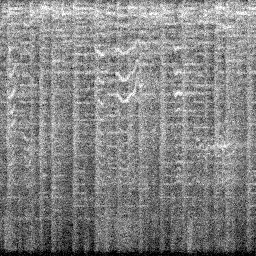

In [ ]:
mel_noisy = Mel(image=image)
display(mel_noisy.get_image())
mel_noisy.get_audio()

In [ ]:
print(noisy_image.device)
print(timesteps.device)
print(sample_latent.device)
timesteps = timesteps.to(device)


cuda:0
cpu
cuda:0


In [ ]:
import torch.nn.functional as F


noise_pred = model(noisy_image, timesteps, encoder_hidden_states=sample_latent).sample
loss = F.mse_loss(noise_pred, noise)
loss

tensor(1.0811, device='cuda:0', grad_fn=<MseLossBackward0>)

In [ ]:
with torch.no_grad():
    unconditional_image = torch.zeros((1, 1, 256, 256), device=device)
    mu, log_var = vae.encode(unconditional_image)
    unconditional_latent = torch.cat((mu, log_var), dim=1)
    min_val = unconditional_latent.min()
    max_val = unconditional_latent.max()
    print(unconditional_latent)
    uncond_latent = unconditional_latent.unsqueeze(0)
    print(uncond_latent.shape)

tensor([[  3.0611,   0.2950,   0.3830,   1.1757,  -1.8418,   0.4108,   7.1011,
          -2.4382,  -1.2881,  -0.7944,  -1.8836,   2.2427,   4.2210,  -2.7268,
           2.1582,  -1.3833,  -0.3554,  -2.3695,   1.5800,   9.4169,   1.0630,
          -1.0224,   6.4796,  -0.7365,  -1.4928,  -6.9221,   0.5907,  -4.7511,
          -2.5952,  -7.0451,   1.2950,   3.3189, -22.4423, -23.0652, -21.3000,
         -19.6053, -21.7753, -21.3400, -23.0333, -22.9126, -22.3715, -21.6684,
         -21.8085, -21.6594, -21.2570, -22.5677, -22.4012, -22.6686, -24.8073,
         -20.3275, -20.7623, -23.0038, -20.4970, -20.3420, -23.4486, -22.2792,
         -21.3627, -22.1416, -20.3048, -21.2284, -21.0680, -22.0745, -21.0860,
         -21.4098]], device='cuda:0')
torch.Size([1, 1, 64])


In [ ]:
embeddings = torch.cat([uncond_latent, sample_latent])
embeddings.shape

torch.Size([2, 1, 64])

In [ ]:
generator = torch.Generator(device=device)

noise = torch.randn(
    (config.eval_batch_size, 1, config.image_size, config.image_size),
    generator=generator,
    device=device,
)
noise.shape

torch.Size([1, 1, 256, 256])

100%|██████████| 1000/1000 [00:39<00:00, 25.51it/s]


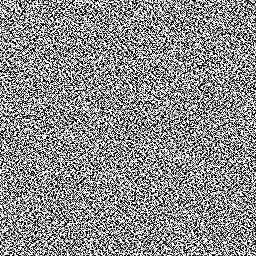

0000_process.png:   0%|          | 0.00/1.64M [00:00<?, ?B/s]

In [ ]:
from diffusers.utils import make_image_grid
import os
import math

# to make same regeneration possible every time
torch.manual_seed(config.seed)
torch.cuda.manual_seed_all(42)

def evaluate(config, epoch, unet, scheduler, vae, index):
    _, sample_latent = hf_dataset.__getitem__(index)
    sample_latent = sample_latent.unsqueeze(0)


    with torch.no_grad():
        uncond_image = torch.zeros((1, 1, 256, 256), device=device)
        mu, log_var = vae.encode(uncond_image)
        uncond_latent = torch.cat((mu, log_var), dim=1)
        uncond_latent = uncond_latent.unsqueeze(0)

    embeddings = torch.cat([uncond_latent, sample_latent])

    generator = torch.Generator(device=device)

    noise = torch.randn(
        (config.eval_batch_size, 1, config.image_size, config.image_size),
        generator=generator,
        device=device,
    )
    images = []
    for t in tqdm(scheduler.timesteps):
        image_model_input = torch.cat([noise] * 2)
        # torch.Size([2, 1, 256, 256])
        image_model_input = scheduler.scale_model_input(image_model_input, timestep=t)
        # torch.Size([2, 1, 256, 256])

        with torch.no_grad():
            noise_pred = unet(image_model_input, t, encoder_hidden_states=embeddings).sample
        noise_pred_uncond, noise_pred_img = noise_pred.chunk(2)
        # torch.Size([1, 1, 256, 256])
        # torch.Size([1, 1, 256, 256])
        noise_pred = noise_pred_uncond + config.guidance_scale * (noise_pred_img - noise_pred_uncond)
        # torch.Size([1, 1, 256, 256])
        # compute the previous noisy sample x_t -> x_t-1
        noise = scheduler.step(noise_pred, t, noise).prev_sample
        if t % 100 == 0:
            images.append(noise)

    output_image = []
    for l, image in enumerate(images):
      image_tensor = image.squeeze(1)  # Shape will be [1, 256, 256]
      mel = tensor_to_mel(image_tensor)
      i = mel.get_image()
      output_image.append(i)
    images_grid = make_image_grid(output_image, rows=len(output_image), cols=1)
    image_grid = make_image_grid([output_image[-1]], rows=1, cols=1)
    # Save the images
    output_dir = f"{config.output_dir}/epoch_{epoch}"
    test_dir = os.path.join(output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    images_grid.save(f"{test_dir}/{epoch:04d}_process.png")
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

    display(mel.get_image())
    mel.get_audio()


evaluate(config, 0, model, noise_scheduler, vae, 0)

output_dir = f"{config.output_dir}/epoch_{0}"
os.makedirs(output_dir, exist_ok=True)

# Save the full pipeline including model, scheduler, etc.

if config.push_to_hub:
  upload_folder(
      repo_id=config.hub_model_id,
      folder_path=output_dir,
      commit_message=f"Epoch {0}",
      ignore_patterns=["step_*", "epoch_*"],
      token=os.environ["HF_TOKEN"]
  )

## train

In [ ]:
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler, vae_model):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=config.hub_model_id or Path(config.output_dir).name,
                exist_ok=True,
                token=os.environ["HF_TOKEN"],
                private=config.hub_private_repo,
            ).repo_id

        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.start_epoch, config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch[0]
            latents = batch[1]

            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, encoder_hidden_states=latents, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)



            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, model, noise_scheduler, vae_model, 0)

                output_dir = f"{config.output_dir}/epoch_{epoch}"
                os.makedirs(output_dir, exist_ok=True)

                # Save the full pipeline including model, scheduler, etc.
                pipeline.save_pretrained(output_dir)
                torch.save({
                    "optimizer": optimizer.state_dict(),
                    "lr_scheduler": lr_scheduler.state_dict(),
                    "config": config.__dict__,
                    "epoch": epoch,
                }, os.path.join(output_dir, "training_state.pt"))

                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                        token=os.environ["HF_TOKEN"]
                    )

Launching training on one GPU.


  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

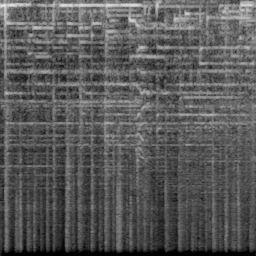

training_state.pt:   0%|          | 0.00/944M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

0009_process.png:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/472M [00:00<?, ?B/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

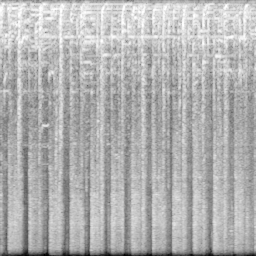

training_state.pt:   0%|          | 0.00/944M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

0019_process.png:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/472M [00:00<?, ?B/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

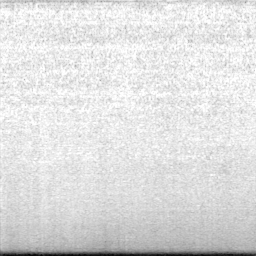

0029_process.png:   0%|          | 0.00/1.56M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

training_state.pt:   0%|          | 0.00/944M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/472M [00:00<?, ?B/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

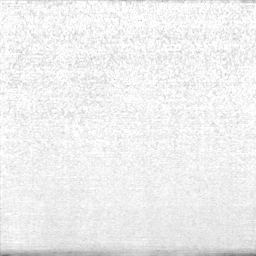

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

training_state.pt:   0%|          | 0.00/944M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/472M [00:00<?, ?B/s]

0039_process.png:   0%|          | 0.00/1.54M [00:00<?, ?B/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

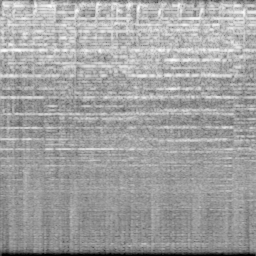

training_state.pt:   0%|          | 0.00/944M [00:00<?, ?B/s]

0049_process.png:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/472M [00:00<?, ?B/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

  0%|          | 0/1199 [00:00<?, ?it/s]

In [ ]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, dataloader, lr_scheduler, vae)

notebook_launcher(train_loop, args, num_processes=1)

In [ ]:
from google.colab import runtime
print("done")
runtime.unassign()